In [33]:
from keras.models import Sequential
import numpy as np
from keras.preprocessing import sequence
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.layers.core import TimeDistributedDense, Activation
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from sklearn.cross_validation import train_test_split
from keras.layers import Merge
from keras.backend import tf

from sklearn.metrics import confusion_matrix, accuracy_score
raw = open('wikigold.conll.txt', 'r').readlines()
print len(raw)
all_x = []
point = []
for line in raw:
    stripped_line = line.strip().split(' ')
    point.append(stripped_line)
    if line == '\n':
        all_x.append(point[:-1])
        point = []
all_x = all_x[:-1]
print len(all_x)

def encode(x, n):
    result = np.zeros(n)
    result[x] = 1
    return result

40992
1839


In [34]:
lengths = [len(x) for x in all_x]
short_x = [x for x in all_x if len(x) < 64]
X = [[c[0] for c in x] for x in short_x]
y = [[c[1] for c in y] for y in short_x]
all_text = [c for x in X for c in x]
words = list(set(all_text))
word2ind = {word: index for index, word in enumerate(words)}
ind2word = {index: word for index, word in enumerate(words)}
labels = list(set([c for x in y for c in x]))
label2ind = {label: (index + 1) for index, label in enumerate(labels)}
ind2label = {(index + 1): label for index, label in enumerate(labels)}
maxlen = max([len(x) for x in X])
print label2ind

0 I-MISC
1 I-LOC
2 I-ORG
3 O
4 I-PER
{'I-MISC': 1, 'I-LOC': 2, 'I-ORG': 3, 'O': 4, 'I-PER': 5}


In [35]:
from nltk import FreqDist
fd = FreqDist()
for i in y:
    fd.update(i)
for i in fd:
    print i, fd[i]

O 31414
I-ORG 1925
I-PER 1526
I-LOC 1403
I-MISC 1313


In [36]:
X_enc = [[word2ind[c] for c in x] for x in X]
max_label = max(label2ind.values())  + 1

y_enc = [[0] * (maxlen - len(ey)) + [label2ind[c] for c in ey] for ey in y]
y_enc = [[encode(c, max_label) for c in ey] for ey in y_enc]

X = pad_sequences(X_enc, maxlen=maxlen)
Y = pad_sequences(y_enc, maxlen=maxlen)

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.332, random_state=42)

print 'Training and testing tensor shapes:'
print X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

Training and testing tensor shapes:
(1215, 63) (604, 63) (1215, 63, 6) (604, 63, 6)


In [37]:
max_features = len(word2ind)
embedding_size = 128
hidden_size = 32
out_size = len(label2ind)  + 1 

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Bidirectional(LSTM(hidden_size, return_sequences = True)))
model.add(TimeDistributedDense(out_size, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10, validation_split=0.1)

Train on 1093 samples, validate on 122 samples
Epoch 1/10
1093/1093 [==============================] - 11s - loss: 0.9944 - acc: 0.7941 - val_loss: 0.4266 - val_acc: 0.9092

In [28]:
score = model.evaluate(X_test, Y_test)

print('Test score:', score[0])
print('Test accuracy:', score[1])

604/604 [==============================] - 0s     
('Test score:', 0.12445567785114642)
('Test accur

In [29]:
pred = model.predict(X_test)
Y_pred = []
Y_test_1dim = []
for i in range(len(pred)):
    for j in range(len(pred[i])):
        pred_label = np.argmax(pred[i][j])
        Y_pred.append(pred_label)
        test_label = np.argmax(Y_test[i][j])
        Y_test_1dim.append(test_label)
print confusion_matrix(Y_pred, Y_test_1dim)
print pred.shape, Y_test.shape

[[25497     7    10    21    38    45]
 [    0    83    24    32    13    17]
 [    0     4    91     4     1     1]
 [    0    62   126   301    19    88]
 [    0   210   214   278 10511   231]
 [    0     5    13     4     2   100]]
(604, 63, 6) (604, 63, 6)


In [30]:
from sklearn.metrics import classification_report
print classification_report(Y_pred, Y_test_1dim)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     25618
          1       0.22      0.49      0.31       169
          2       0.19      0.90      0.31       101
          3       0.47      0.51      0.49       596
          4       0.99      0.92      0.95     11444
          5       0.21      0.81      0.33       124

avg / total       0.98      0.96      0.97     38052



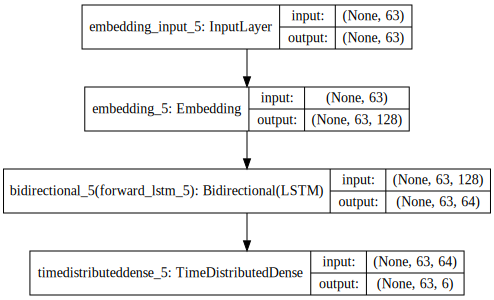

In [41]:
%matplotlib inline
from IPython.display import SVG
from matplotlib import pyplot as plt
from keras.utils.visualize_util import model_to_dot, plot
plt.style.use("ggplot")
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))